In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/kuc-hackathon-winter-2018/drugsComTest_raw.csv
/kaggle/input/kuc-hackathon-winter-2018/drugsComTrain_raw.csv


In [2]:
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
import matplotlib.pyplot as plt
import re
import random
from spacy.util import minibatch, compounding
import os
import numpy as np # linear algebra
import pandas as pd

In [3]:
df_train = pd.read_csv('/kaggle/input/kuc-hackathon-winter-2018/drugsComTrain_raw.csv')
df_train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [4]:
comment_words = ' '
stopwords = set(STOPWORDS) 
for review in df_train['review']: 
    # typecaste each val to string 
    review = str(review).lower() 
    
    # split the value 
    tokens = review.split()
    comment_words = comment_words + ' '.join(tokens)

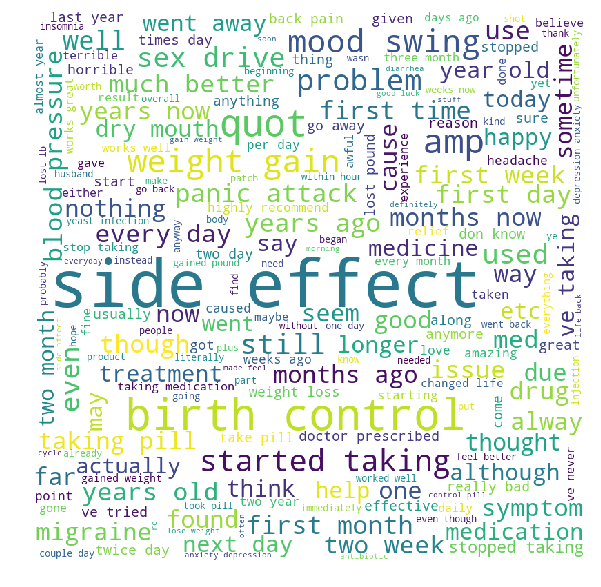

In [5]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [6]:
df_train.shape

(161297, 7)

In [7]:
drug_list = df_train['drugName'].value_counts().index.tolist()
drug_list = [x.lower() for x in drug_list]

In [8]:
nlp = spacy.load('en_core_web_sm')
count = 0
for review in df_train['review']:
    if count < 11:
        doc = nlp(review)
        ents = [(e.text, e.label_) for e in doc.ents if e.label_ not in ('DATE', 'TIME', 'ORDINAL', 'CARDINAL')]
        print(ents)
    count += 1

[]
[('Intuniv', 'PERSON')]
[('US', 'GPE'), ('Lybrel', 'GPE'), ('Lybrel', 'GPE'), ('Alas', 'PERSON')]
[]
[]
[('Leg', 'PERSON'), ('2', 'MONEY'), ('230', 'MONEY')]
[]
[('Abilify', 'PERSON'), ('Zoloft', 'PERSON'), ('Clonidine', 'PERSON'), ('Abilify', 'PERSON'), ('Zoloft', 'PERSON'), ('Clondine', 'PERSON'), ('2mg', 'QUANTITY'), ('Abilify', 'PERSON'), ('Abilify', 'PERSON')]
[('Keppera', 'ORG'), ('&amp', 'ORG')]
[]
[]


In [9]:
def process_review(review):
    processed_token = []
    for token in review.split():
        token = ''.join(e.lower() for e in token if e.isalnum())
        processed_token.append(token)
    return ' '.join(processed_token)

In [10]:
count = 0
TRAIN_DATA = []
for _, item in df_train.iterrows():
    ent_dict = {}
    if count < 1000:
        review = process_review(item['review'])
        #We will find a drug and its positions once and add to the visited items.
        visited_items = []
        entities = []
        for token in review.split():
            if token in drug_list:
                for i in re.finditer(token, review):
                    if token not in visited_items:
                        entity = (i.span()[0], i.span()[1], 'DRUG')
                        visited_items.append(token)
                        entities.append(entity)
        if len(entities) > 0:
            ent_dict['entities'] = entities
            train_item = (review, ent_dict)
            TRAIN_DATA.append(train_item)
            count+=1

In [11]:
n_iter = 10
def train():
    nlp = spacy.blank("en")  # create blank Language class
    print("Created blank 'en' model")
    
    if "ner" not in nlp.pipe_names:
        ner = nlp.create_pipe("ner")
        nlp.add_pipe(ner, last=True)
    # otherwise, get it so we can add labels
    else:
        ner = nlp.get_pipe("ner")
        
    # add labels
    for _, annotations in TRAIN_DATA:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])
            
    nlp.begin_training()
    for itn in range(n_iter):
        random.shuffle(TRAIN_DATA)
        losses = {}
        # batch up the examples using spaCy's minibatch
        batches = minibatch(TRAIN_DATA, size=compounding(4.0, 32.0, 1.001))
        for batch in batches:
            texts, annotations = zip(*batch)
            nlp.update(
                texts,  # batch of texts
                annotations,  # batch of annotations
                drop=0.5,  # dropout - make it harder to memorise data
                losses=losses,
            )
        print("Losses", losses)
    return nlp

In [12]:
nlp2 = train()

Created blank 'en' model
Losses {'ner': 4601.63463723813}
Losses {'ner': 1426.41035177893}
Losses {'ner': 994.9367654680124}
Losses {'ner': 850.7645644223845}
Losses {'ner': 722.5938530351862}
Losses {'ner': 645.4462169470912}
Losses {'ner': 608.321199475359}
Losses {'ner': 551.4914184026802}
Losses {'ner': 529.7232852345167}
Losses {'ner': 488.22963106146454}


In [13]:
for text, _ in TRAIN_DATA[:10]:
    doc = nlp2(text)
    print("Entities", [(ent.text, ent.label_) for ent in doc.ents])

Entities [('ocella', 'DRUG'), ('yaz', 'DRUG'), ('yasmin', 'DRUG')]
Entities [('skyla', 'DRUG'), ('ibuprofen', 'DRUG')]
Entities [('cymbalta', 'DRUG'), ('venlafaxine', 'DRUG'), ('prozac', 'DRUG')]
Entities [('focalin', 'DRUG')]
Entities [('pristiq', 'DRUG')]
Entities [('percocet', 'DRUG')]
Entities [('cialis', 'DRUG')]
Entities [('bactrim', 'DRUG')]
Entities [('beyaz', 'DRUG')]
Entities [('skyla', 'DRUG')]


In [14]:
test_reviews = df_train.iloc[-10:, :]['review']
for review in test_reviews:
    review = process_review(review)
    print(review)
    doc = nlp2(review)
    print("Entities", [(ent.text, ent.label_) for ent in doc.ents])
    print('________________________')

i was super against taking medication i039ve started dealing with anxiety some depression for awhile now i got prescribed ativan months ago and never took it i thought i could handle myself again but then my relationship started to fail because of my over thinking i went back to the doctor and decided to try it she prescribed me 50 3 times a day i took a full one at night after a bad panic attack and within 30 minutes i was calm and slept through the entire night i have only been taking a half morning and mid afternoon and full at night because it does make you feel tired my brain is in a slight fog but nothing crazy i still know whats going on though  give it a try if you are suffering you will know after 1
Entities [('ativan', 'DRUG')]
________________________
i have been off prozac for about 4 weeks nowafter starting 2 years ago for a terrible depressionsadnessmenopause wanted to take a holiday to see what would happen when on prozac side effects like decrease sexual drive and sligh

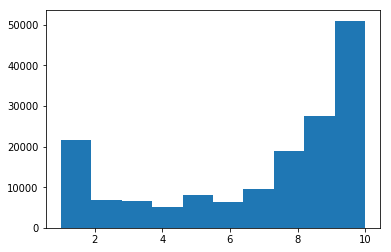

In [15]:
train = pd.read_csv('/kaggle/input/kuc-hackathon-winter-2018/drugsComTrain_raw.csv')
test = pd.read_csv('/kaggle/input/kuc-hackathon-winter-2018/drugsComTest_raw.csv')
plt.hist(train.rating)
plt.show()

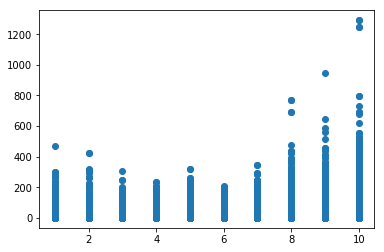

In [16]:
plt.scatter(train.rating, train.usefulCount)
plt.show()


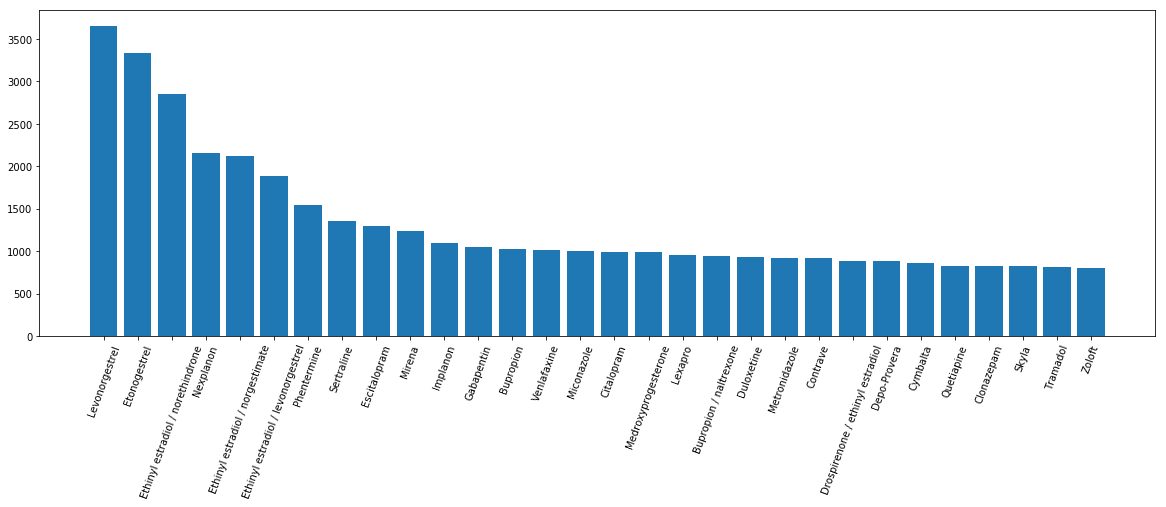

In [17]:
drugcounts = train['drugName'].value_counts()
drugcounts_filtered = drugcounts[drugcounts >= 10]

plt.figure(figsize=(20,6))
plt.bar(drugcounts[:30].index, drugcounts[:30])
plt.xticks(rotation=70)
plt.show()


In [18]:
filtered_train = train[train['drugName'].isin(drugcounts_filtered.index)]
print(train.shape)
print(filtered_train.shape)

(161297, 7)
(155300, 7)


In [19]:
rating_avgs = (filtered_train['rating'].groupby(filtered_train['drugName']).mean())
rating_avgs.sort_values()

drugName
ProAir RespiClick                                    1.193548
Monistat 1-Day or Night Combination Pack             1.416667
Yuvafem                                              2.318182
Alendronate                                          2.954545
Monistat 7                                           3.032258
                                                      ...    
Dexbrompheniramine / pseudoephedrine                 9.947368
Drixoral Cold and Allergy                            9.948718
Silver sulfadiazine                                  9.972222
Zutripro                                            10.000000
Chlorpheniramine / hydrocodone / pseudoephedrine    10.000000
Name: rating, Length: 1381, dtype: float64

In [20]:
illnesscounts = train['condition'].value_counts()
illnesscounts = illnesscounts[illnesscounts > 20]
print(illnesscounts)

Birth Control                         28788
Depression                             9069
Pain                                   6145
Anxiety                                5904
Acne                                   5588
                                      ...  
Hyperphosphatemia of Renal Failure       21
Melanoma, Metastatic                     21
Tinea Pedis                              21
Atrial Flutte                            21
Insulin Resistance Syndrome              21
Name: condition, Length: 325, dtype: int64


In [21]:
df = pd.DataFrame({"rating_avgs":rating_avgs}) 

In [22]:
df

,rating_avgs
drugName,
Abacavir / dolutegravir / lamivudine,8.211538
Abatacept,7.157895
Abilify,6.540359
Abreva,5.727848
Acamprosate,8.899083
...,...
Zyprexa,6.389222
Zyprexa Zydis,6.333333
Zyrtec,7.492754
